## Import Libraries

In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# For reproducibility
np.random.seed(42)

## Load and Inspect the Data


In [65]:
# Load the datasets
permit_types_df = pd.read_csv('Updated_SoundOrdinancePermits.csv')
time_data_df = pd.read_csv('TimesCleanedCompanyType.csv')

## Data Preparation and Cleaning


In [66]:
# Convert date columns to datetime if needed
if 'IN_DATE' in time_data_df.columns and time_data_df['IN_DATE'].dtype != 'datetime64[ns]':
    time_data_df['IN_DATE'] = pd.to_datetime(time_data_df['IN_DATE'])

if 'ISSUE_DATE' in time_data_df.columns and time_data_df['ISSUE_DATE'].dtype != 'datetime64[ns]':
    time_data_df['ISSUE_DATE'] = pd.to_datetime(time_data_df['ISSUE_DATE'])

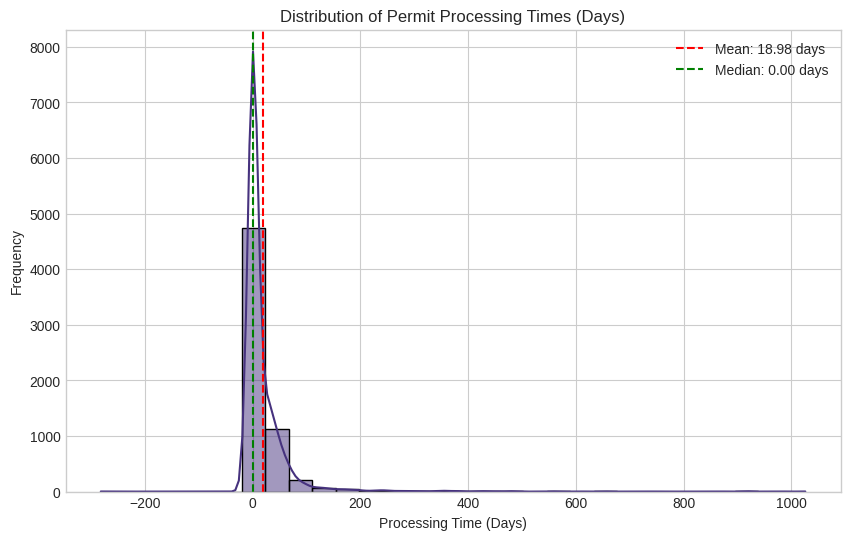

In [67]:
# Check if processing time is already calculated or if we need to calculate it
if 'time_diff' not in time_data_df.columns:
    # Calculate the processing time in days
    time_data_df['time_diff'] = (time_data_df['ISSUE_DATE'] - time_data_df['IN_DATE']).dt.days

# Display the distribution of processing times
plt.figure(figsize=(10, 6))
sns.histplot(time_data_df['time_diff'], bins=30, kde=True)
plt.title('Distribution of Permit Processing Times (Days)')
plt.xlabel('Processing Time (Days)')
plt.ylabel('Frequency')
plt.axvline(time_data_df['time_diff'].mean(), color='r', linestyle='--', label=f'Mean: {time_data_df["time_diff"].mean():.2f} days')
plt.axvline(time_data_df['time_diff'].median(), color='g', linestyle='--', label=f'Median: {time_data_df["time_diff"].median():.2f} days')
plt.legend()
plt.show()

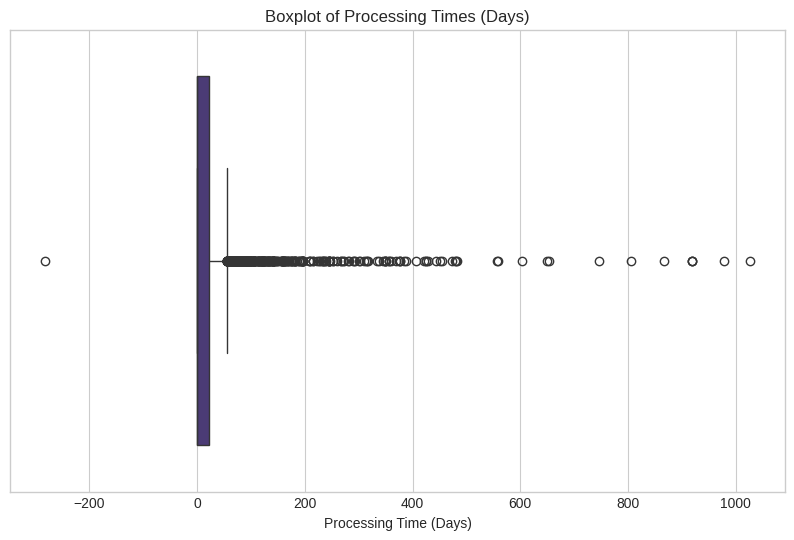

Statistics for Processing Time (Days):
count    6273.000000
mean       18.981189
std        55.193791
min      -282.000000
25%         0.000000
50%         0.000000
75%        22.000000
max      1026.000000
Name: time_diff, dtype: float64


In [68]:
# Check for outliers in processing time
plt.figure(figsize=(10, 6))
sns.boxplot(x=time_data_df['time_diff'])
plt.title('Boxplot of Processing Times (Days)')
plt.xlabel('Processing Time (Days)')
plt.show()

# Calculate statistics for processing time
time_stats = time_data_df['time_diff'].describe()
print("Statistics for Processing Time (Days):")
print(time_stats)

## Merge Datasets

Merge the two datasets based on the SUB_TYPE field, which appears in both datasets.

In [69]:
# Group time_data_df by SUB_TYPE and calculate the average processing time
avg_times_by_subtype = time_data_df.groupby('SUB_TYPE')['time_diff'].agg(['mean', 'median', 'count']).reset_index()
avg_times_by_subtype.columns = ['SUB_TYPE', 'avg_time', 'median_time', 'permit_count']

# Merge with permit types data
merged_df = pd.merge(permit_types_df, avg_times_by_subtype, on='SUB_TYPE', how='left')

# Drop rows with missing values in the target variable
merged_df_clean = merged_df.dropna(subset=['avg_time'])

## Exploratory Data Analysis

Explore the relationships between company types, permit subtypes, and processing times.

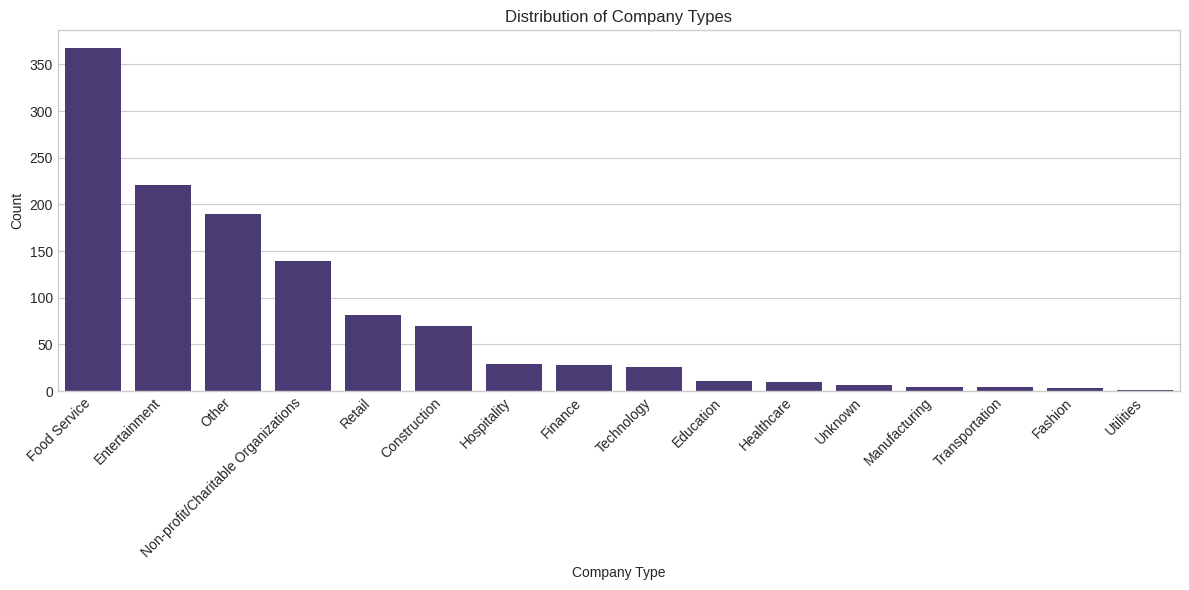

In [70]:
# Distribution of company types
plt.figure(figsize=(12, 6))
company_counts = merged_df_clean['COMPANY_TYPES'].value_counts()
sns.barplot(x=company_counts.index, y=company_counts.values)
plt.title('Distribution of Company Types')
plt.xlabel('Company Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

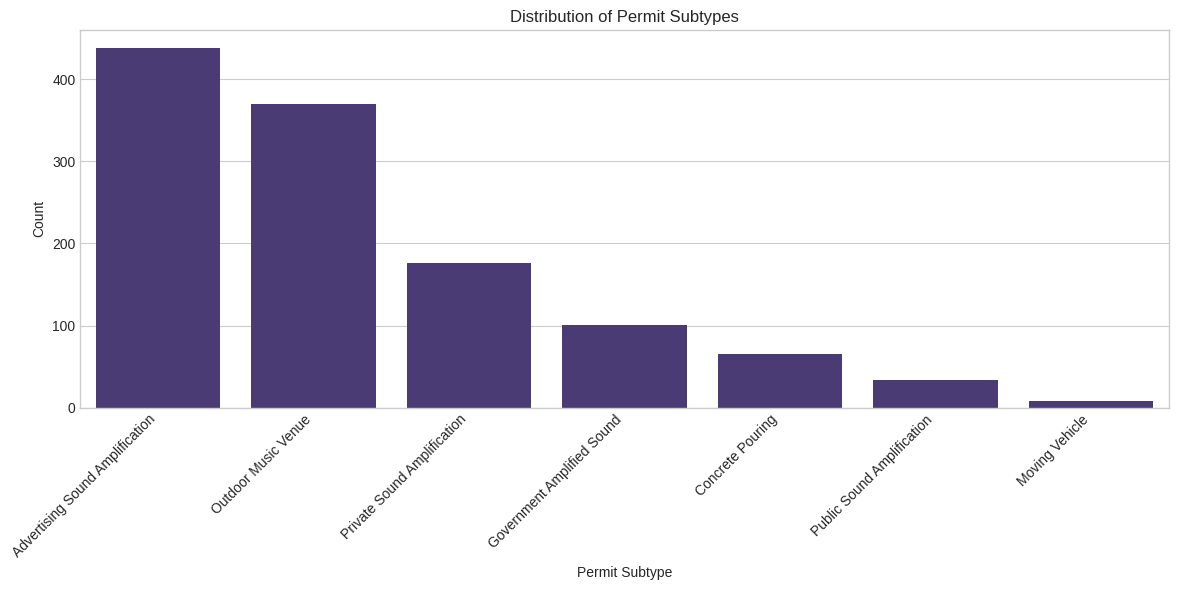

In [71]:
# Distribution of permit subtypes
plt.figure(figsize=(12, 6))
subtype_counts = merged_df_clean['SUB_TYPE'].value_counts()
sns.barplot(x=subtype_counts.index, y=subtype_counts.values)
plt.title('Distribution of Permit Subtypes')
plt.xlabel('Permit Subtype')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

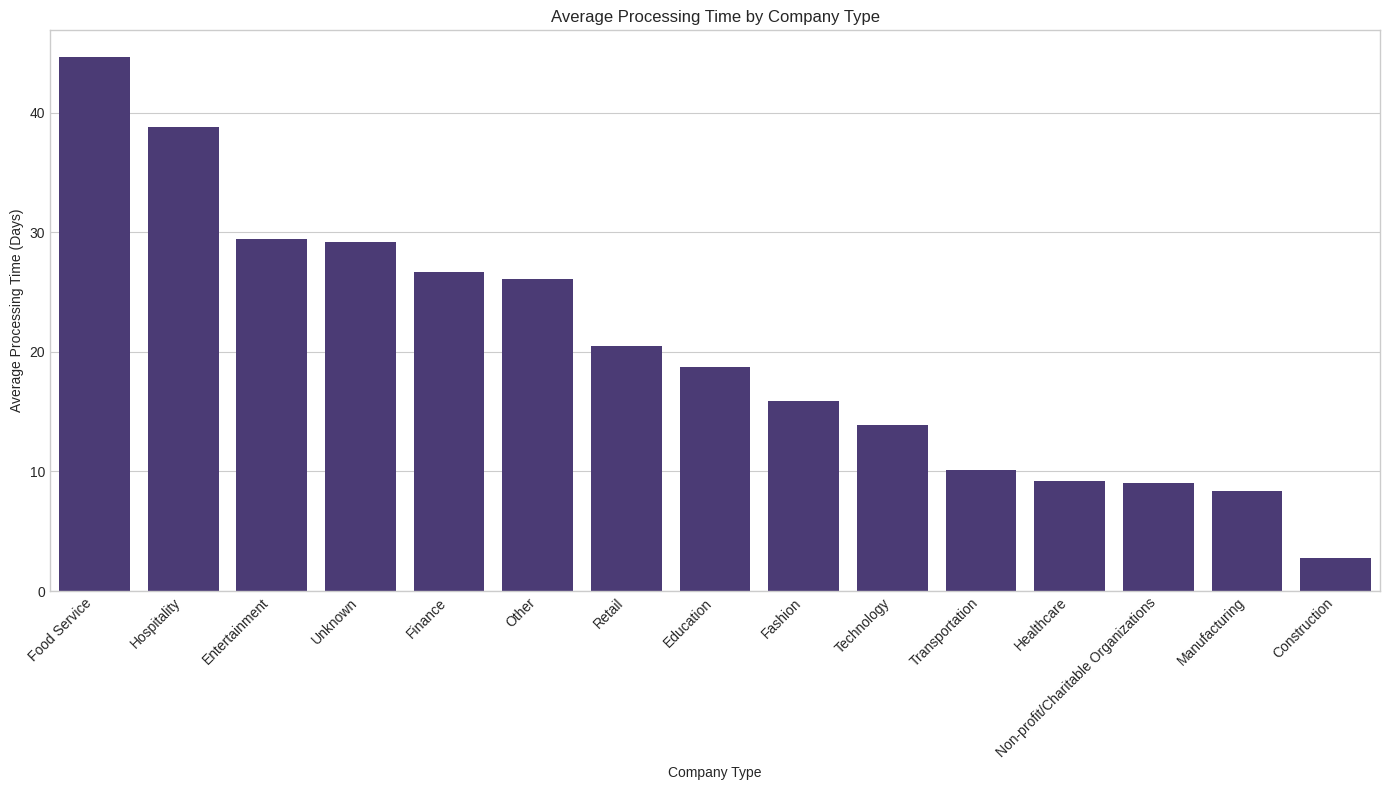

In [72]:
# Average processing time by company type
plt.figure(figsize=(14, 8))
company_avg_times = merged_df_clean.groupby('COMPANY_TYPES')['avg_time'].mean().sort_values(ascending=False)
company_counts = merged_df_clean['COMPANY_TYPES'].value_counts()
# Only show company types with at least 3 permits
company_avg_times = company_avg_times[company_counts[company_avg_times.index] >= 3]

sns.barplot(x=company_avg_times.index, y=company_avg_times.values)
plt.title('Average Processing Time by Company Type')
plt.xlabel('Company Type')
plt.ylabel('Average Processing Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

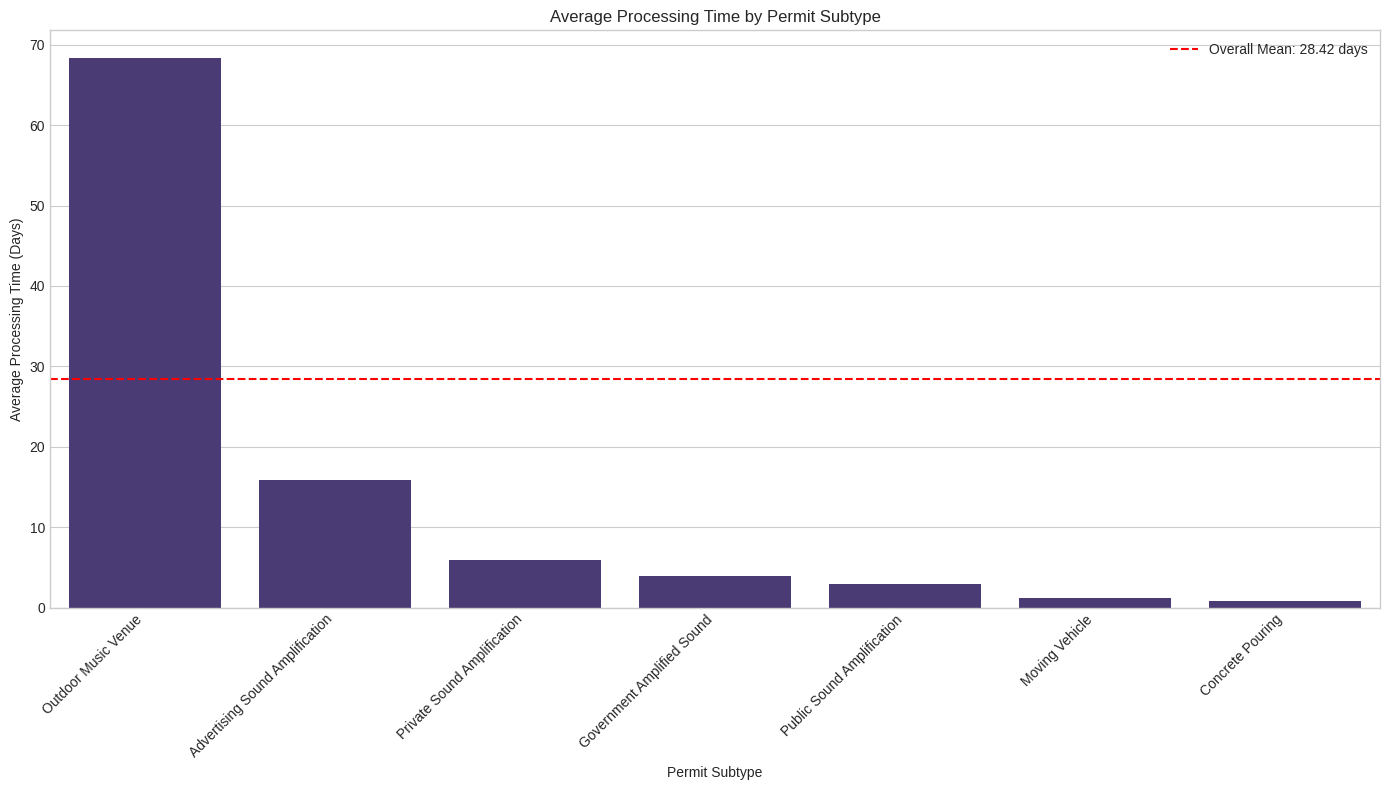

In [73]:
# Average processing time by permit subtype
plt.figure(figsize=(14, 8))
subtype_avg_times = merged_df_clean.groupby('SUB_TYPE')['avg_time'].mean().sort_values(ascending=False)
sns.barplot(x=subtype_avg_times.index, y=subtype_avg_times.values)
plt.title('Average Processing Time by Permit Subtype')
plt.xlabel('Permit Subtype')
plt.ylabel('Average Processing Time (Days)')
plt.axhline(y=merged_df_clean['avg_time'].mean(), color='r', linestyle='--', label=f'Overall Mean: {merged_df_clean["avg_time"].mean():.2f} days')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Predictive Modeling

Build a model to predict permit processing times based on company type and permit subtype.

In [74]:
# Prepare data for modeling
X = merged_df_clean[['COMPANY_TYPES', 'SUB_TYPE']]
y = merged_df_clean['avg_time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [75]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['COMPANY_TYPES', 'SUB_TYPE'])
    ])

# Create model pipelines
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [76]:
# Train and evaluate the linear model
print("Training Linear Regression model...")
linear_pipeline.fit(X_train, y_train)
linear_pred = linear_pipeline.predict(X_test)

# Calculate metrics for linear model
linear_mse = mean_squared_error(y_test, linear_pred)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_pred)
linear_r2 = r2_score(y_test, linear_pred)

print(f"Linear Regression Results:")
print(f"Mean Squared Error: {linear_mse}")
print(f"Root Mean Squared Error: {linear_rmse}")
print(f"Mean Absolute Error: {linear_mae}")
print(f"R² Score: {linear_r2}")

# Train and evaluate the random forest model
print("\nTraining Random Forest model...")
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

# Calculate metrics for random forest model
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"Root Mean Squared Error: {rf_rmse}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"R² Score: {rf_r2}")

Training Linear Regression model...
Linear Regression Results:
Mean Squared Error: 8.172738523991911e-09
Root Mean Squared Error: 9.04031997442121e-05
Mean Absolute Error: 1.9597252664418304e-05
R² Score: 0.9999999999891184

Training Random Forest model...
Random Forest Results:
Mean Squared Error: 0.0001917930780396098
Root Mean Squared Error: 0.013848937794632836
Mean Absolute Error: 0.0017621251643018035
R² Score: 0.9999997446362289


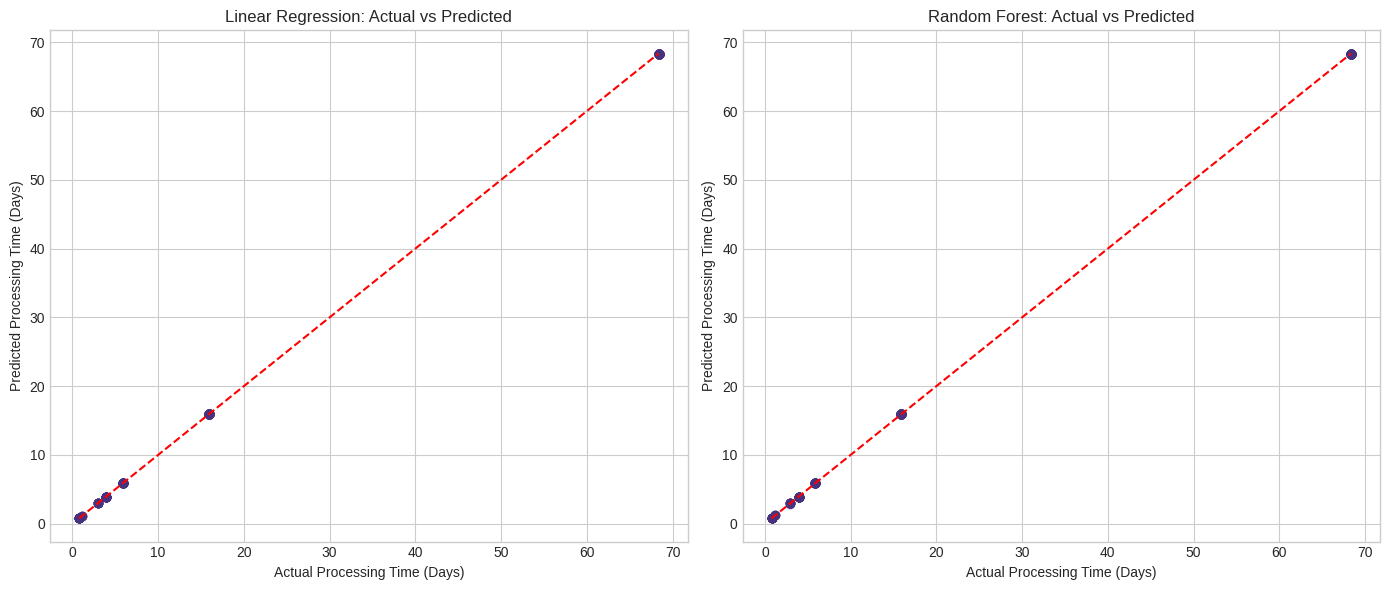

In [77]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, linear_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Processing Time (Days)')
plt.ylabel('Predicted Processing Time (Days)')

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Processing Time (Days)')
plt.ylabel('Predicted Processing Time (Days)')

plt.tight_layout()
plt.show()

## Feature Importance Analysis

Examine which factors have the most influence on permit processing times.

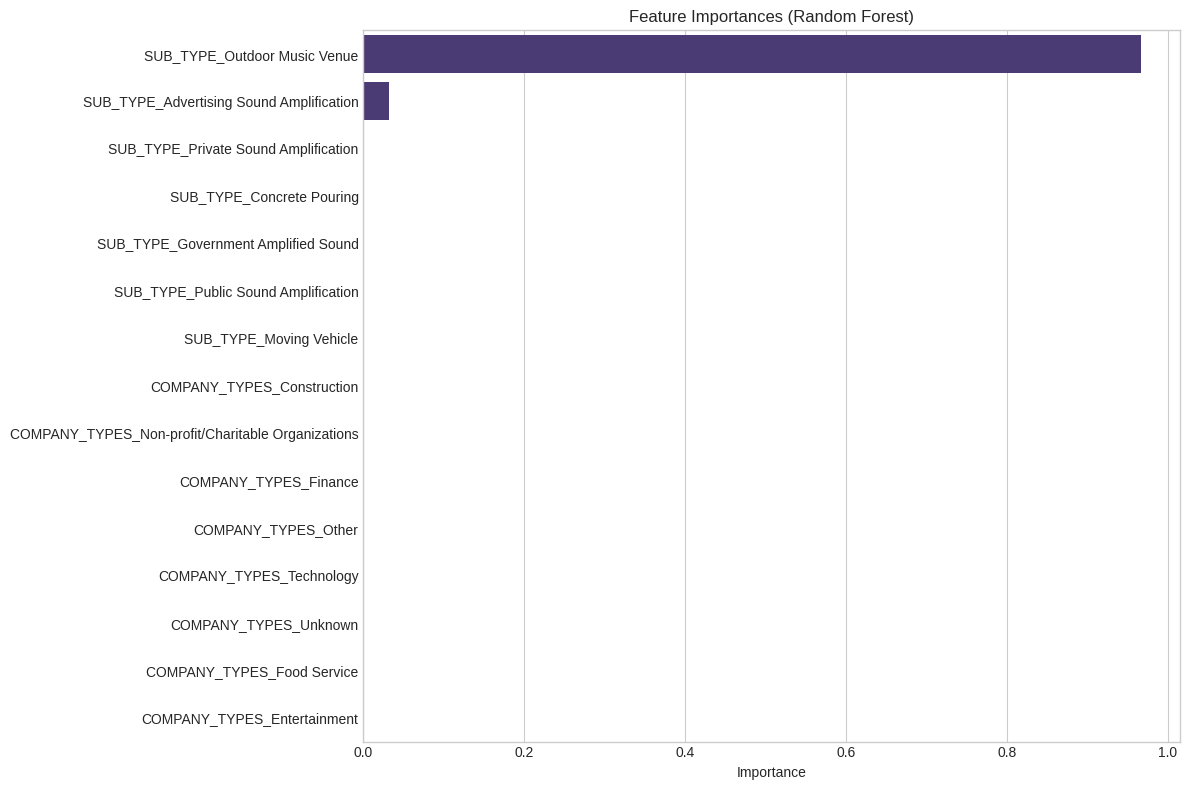

In [78]:
# For the Random Forest model, we can extract feature importances
# We need to get the feature names after one-hot encoding
preprocessor.fit(X)
cat_features = preprocessor.named_transformers_['cat']
feature_names = cat_features.get_feature_names_out(['COMPANY_TYPES', 'SUB_TYPE'])

# Train a simple Random Forest directly (not in pipeline) to get feature importances
X_encoded = preprocessor.transform(X)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_encoded, y)

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 15 most important features
plt.figure(figsize=(12, 8))
top_n = 15  # Show top 15 features
sns.barplot(x=importances[indices[:top_n]], y=[feature_names[i] for i in indices[:top_n]])
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Prediction Function

A function to predict processing time for a given company type and permit subtype.

In [84]:
def predict_processing_time(company_type, sub_type, model=None):
    """Predict the processing time for a given company type and permit subtype."""
    if model is None:
        # Use the better model based on R² score
        if rf_r2 > linear_r2:
            model = rf_pipeline
            model_name = "Random Forest"
        else:
            model = linear_pipeline
            model_name = "Linear Regression"
    else:
        model_name = model.__class__.__name__

    # Create input data
    input_data = pd.DataFrame({
        'COMPANY_TYPES': [company_type],
        'SUB_TYPE': [sub_type]
    })

    # Make prediction using preprocessor from training
    # This ensures consistent feature encoding
    input_data_encoded = preprocessor.transform(input_data)
    predicted_time = model.named_steps['regressor'].predict(input_data_encoded)[0]


    print(f"Predicted processing time for {company_type} applying for {sub_type} permit:")
    print(f"{predicted_time:.2f} days (using {model_name})")

    return predicted_time

In [80]:
def test_processing_time_predictions(test_cases):
    # Create a list to store results
    results = []

    # Process each test case
    for case in test_cases:
        company_type = case['company_type']
        sub_type = case['sub_type']

        # Get prediction
        predicted_time = predict_processing_time(company_type, sub_type)

        # Store result
        results.append({
            'Company Type': company_type,
            'Permit Subtype': sub_type,
            'Predicted Days': predicted_time
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create a visual representation
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Predicted Days', y='Company Type', hue='Permit Subtype', data=results_df)
    plt.title('Predicted Processing Time by Company Type and Permit Subtype')
    plt.tight_layout()
    plt.show()

    return results_df

Predicted processing time for Construction applying for Concrete Pouring permit:
0.77 days (using Linear Regression)
Predicted processing time for Construction applying for Private Sound Amplification permit:
5.89 days (using Linear Regression)
Predicted processing time for Technology applying for Advertising Sound Amplification permit:
15.89 days (using Linear Regression)
Predicted processing time for Technology applying for Private Sound Amplification permit:
5.89 days (using Linear Regression)
Predicted processing time for Food Service applying for Outdoor Music Venue permit:
68.37 days (using Linear Regression)
Predicted processing time for Food Service applying for Private Sound Amplification permit:
5.89 days (using Linear Regression)
Predicted processing time for Food Service applying for Advertising Sound Amplification permit:
15.89 days (using Linear Regression)
Predicted processing time for Hospitality applying for Outdoor Music Venue permit:
68.37 days (using Linear Regressi

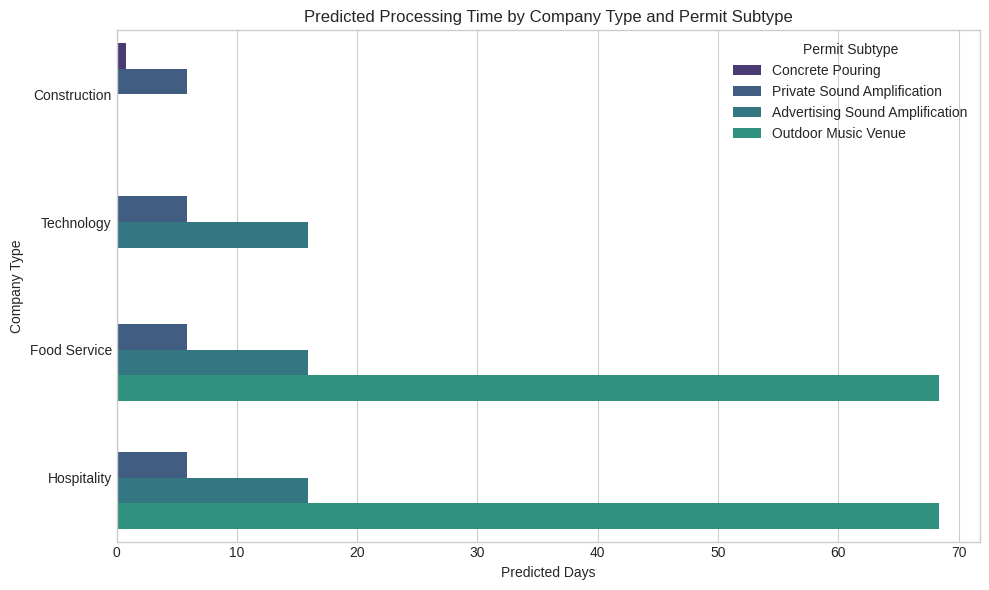

In [85]:
# Define your test cases
test_cases = [
    {'company_type': 'Construction', 'sub_type': 'Concrete Pouring'},
    {'company_type': 'Construction', 'sub_type': 'Private Sound Amplification'},
    {'company_type': 'Technology', 'sub_type': 'Advertising Sound Amplification'},
    {'company_type': 'Technology', 'sub_type': 'Private Sound Amplification'},
    {'company_type': 'Food Service', 'sub_type': 'Outdoor Music Venue'},
    {'company_type': 'Food Service', 'sub_type': 'Private Sound Amplification'},
    {'company_type': 'Food Service', 'sub_type': 'Advertising Sound Amplification'},
    {'company_type': 'Hospitality', 'sub_type': 'Outdoor Music Venue'},
    {'company_type': 'Hospitality', 'sub_type': 'Private Sound Amplification'},
    {'company_type': 'Hospitality', 'sub_type': 'Advertising Sound Amplification'}
]

# Run the test
results = test_processing_time_predictions(test_cases)

## Model Accuracy

Check accuracy of model.

In [82]:
# Perform 5-fold cross-validation
print("Performing 5-fold cross-validation...")

# For Linear Regression
linear_cv_scores = cross_val_score(linear_pipeline, X, y, cv=5, scoring='r2')
print(f"Linear Regression CV Scores: {linear_cv_scores}")
print(f"Mean R² Score: {linear_cv_scores.mean():.2f}, Std Dev: {linear_cv_scores.std():.2f}")

# For Random Forest
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')
print(f"\nRandom Forest CV Scores: {rf_cv_scores}")
print(f"Mean R² Score: {rf_cv_scores.mean():.2f}, Std Dev: {rf_cv_scores.std():.2f}")

Performing 5-fold cross-validation...
Linear Regression CV Scores: [1. 1. 1. 1. 1.]
Mean R² Score: 1.00, Std Dev: 0.00

Random Forest CV Scores: [0.99999996 1.         0.99999998 0.99999998 1.        ]
Mean R² Score: 1.00, Std Dev: 0.00
